# Credit Card Approval Prediction System

#### Dalel Zitouni

### Scope : 

Develop a binary classification model to predict with ensemble trees algorithms , the credit card approval probability using applicant demographic, employment, and financial data.

## Table of Content

[Problem](#problem)   
[Data Understanding](#data_understanding)   
[Data Preparation](#data_preparation)   
[Modeling](#modeling)   
[Evaluation](#evaluation)   
[References](#references)   


## Problem <a class="anchor" id="problem"></a>

Credit card issuers face the challenge of approving legitimate applicants while minimizing default risk. 

The goal is to develop a binary classification model predicting approval status (1=approved, 0=denied) using applicant features like age, income, employment history, and housing status.


## Data Understanding<a class="anchor" id="data_understanding"></a>

What data set are you going to use? Where will you get it from? Describe your data.

**Dataset**: Credit_card and Credit_card_labe.csv from kaggle : 
https://www.kaggle.com/datasets/rohitudageri/credit-card-details/data

The first represents the features and the second the label (our target variable) which we combined to form a single dataset called : 
Credit_Card_Approval_prediction.xlsx

It has 1548 records and 19 variables which are : 

Ind_ID: Client ID

Gender: Gender information

Car_owner: Having car or not

Propert_owner: Having property or not

Children: Count of children

Annual_income: Annual income

Type_Income: Income type

Education: Education level

Marital_status: Marital_status

Housing_type: Living style

Birthday_count: Use backward count from current day (0), -1 means yesterday.

Employed_days: Start date of employment. Use backward count from current day (0). Positive value means, individual is currently unemployed.

Mobile_phone: Any mobile phone

Work_phone: Any work phone

Phone: Any phone number

EMAIL_ID: Any email ID

Type_Occupation: Occupation

Family_Members: Family size

Label: 0 is application approved and 1 is application rejected. (Note that we renamed it to Credit_Card_Approval)

**Let us next perform Exploratory Data Analysis to Understand the data , detect patterns and erros/enhancements to be conisdered in the Feature Engineering Step :**

Dataset shape: (1538, 19)
Total records: 1,538
Features: 19

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1538 entries, 0 to 1537
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Ind_ID                1538 non-null   int64  
 1   GENDER                1531 non-null   object 
 2   Car_Owner             1538 non-null   object 
 3   Propert_Owner         1538 non-null   object 
 4   CHILDREN              1538 non-null   int64  
 5   Annual_income         1516 non-null   float64
 6   Type_Income           1538 non-null   object 
 7   EDUCATION             1538 non-null   object 
 8   Marital_status        1538 non-null   object 
 9   Housing_type          1538 non-null   object 
 10  Birthday_count        1517 non-null   float64
 11  Employed_days         1538 non-null   int64  
 12  Mobile_phone          1538 non-null   int64  
 13  Work_Phone            1538 non-null   int64  
 1

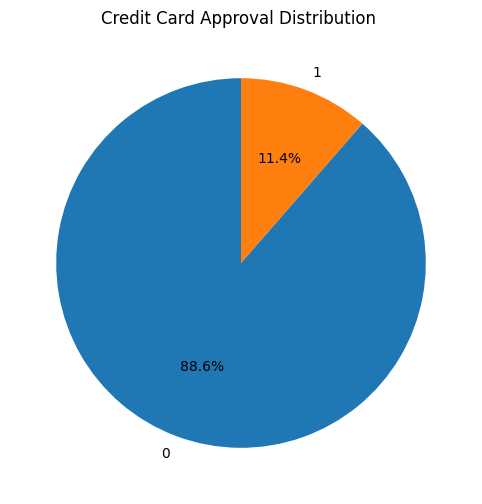


RAW NUMERIC FEATURES SUMMARY
           Ind_ID  CHILDREN  Annual_income  Birthday_count  Employed_days  \
count     1538.00   1538.00        1516.00         1517.00        1538.00   
mean   5078864.28      0.41      191045.50       -16047.53       59766.08   
std      41678.65      0.78      113275.94         4230.81      138165.31   
min    5008827.00      0.00       33750.00       -24946.00      -14887.00   
25%    5045080.75      0.00      121500.00       -19558.00       -3177.50   
50%    5078830.50      0.00      162000.00       -15702.00       -1557.00   
75%    5115610.75      1.00      225000.00       -12417.00        -430.25   
max    5150412.00     14.00     1575000.00        -7705.00      365243.00   

       Mobile_phone  Work_Phone    Phone  EMAIL_ID  Family_Members  
count        1538.0     1538.00  1538.00   1538.00         1538.00  
mean            1.0        0.21     0.31      0.09            2.16  
std             0.0        0.41     0.46      0.29            0.95  


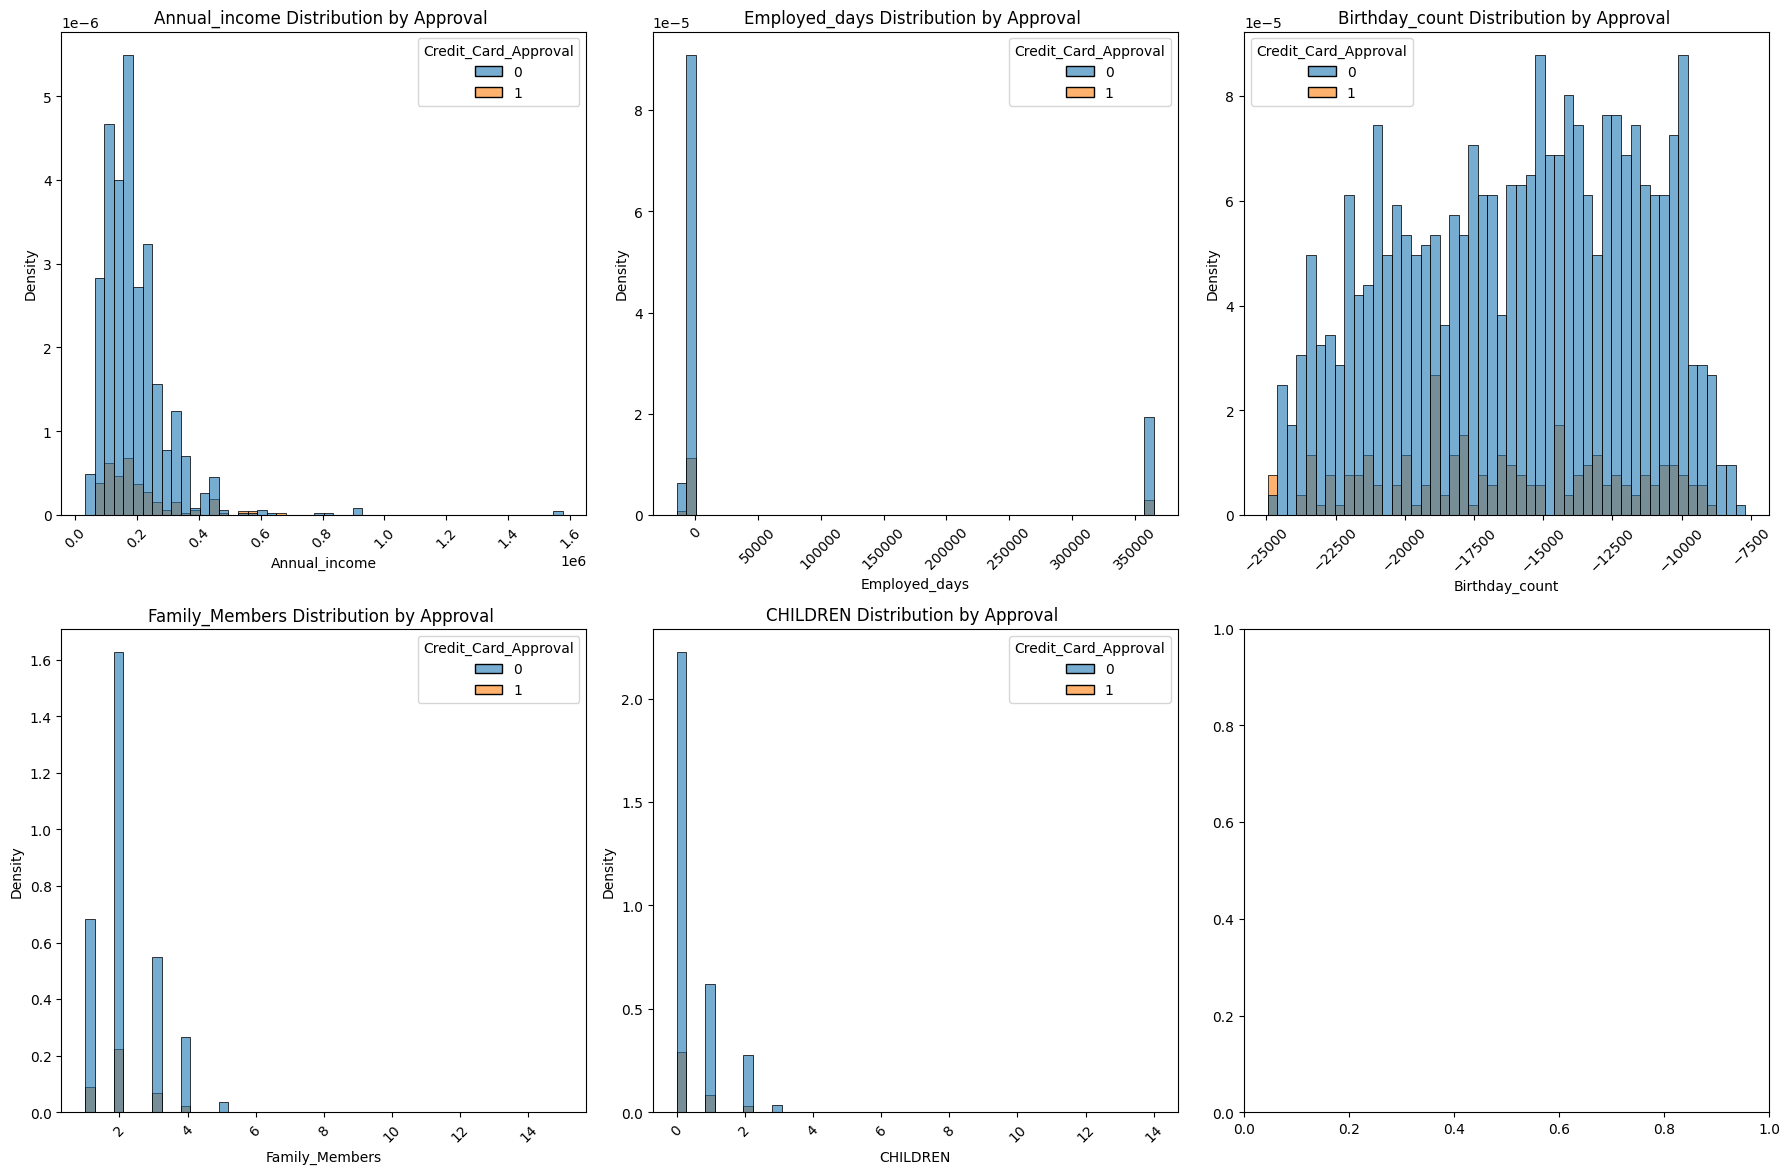

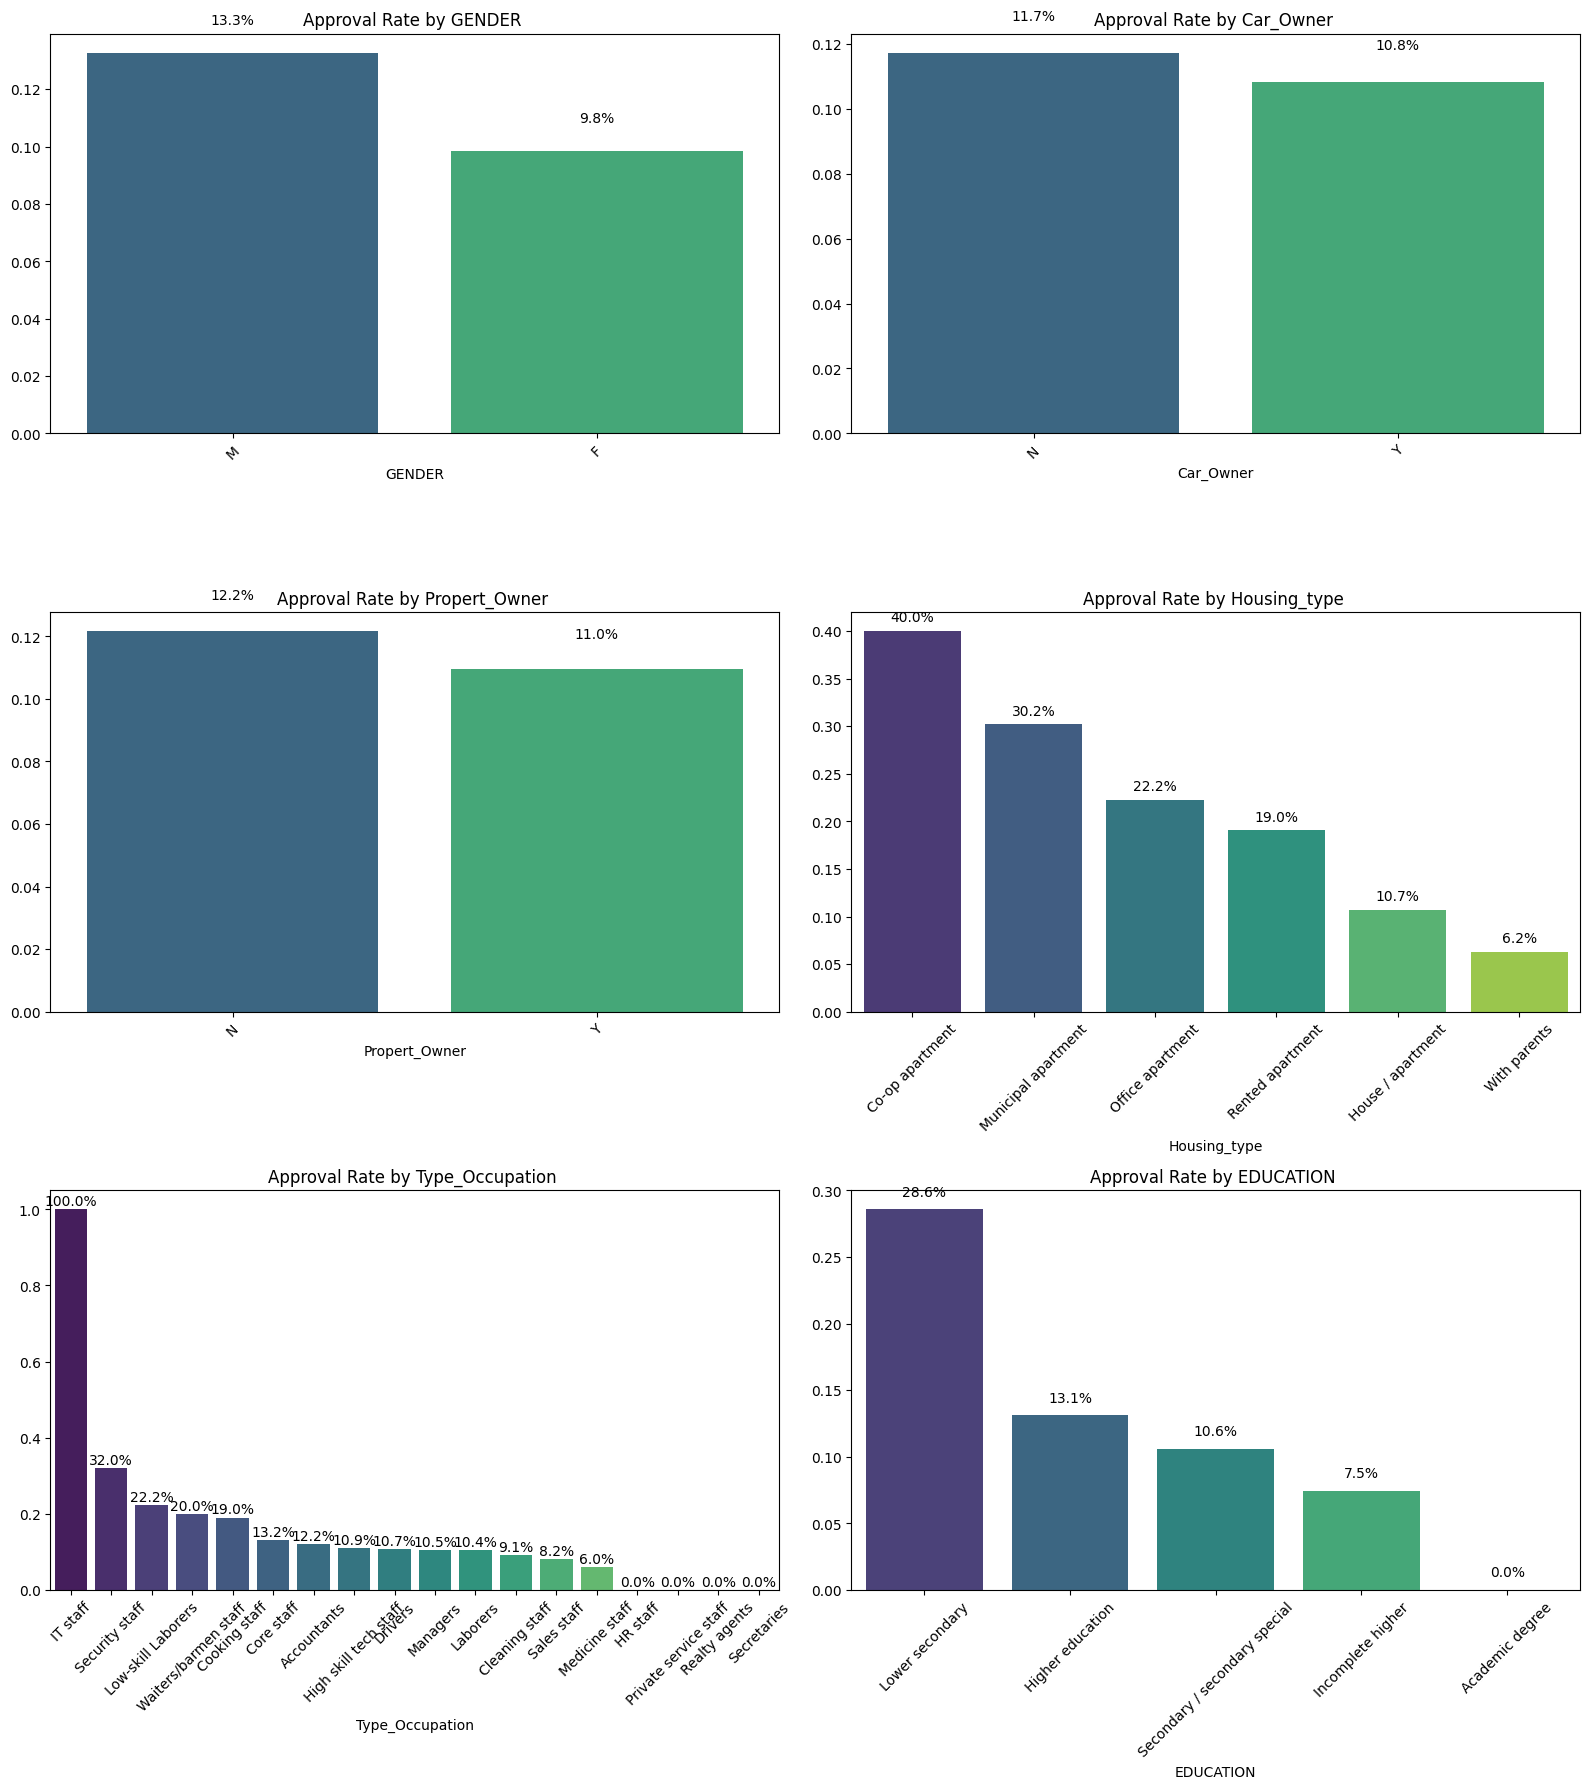

Top 3 Categories by Approval Rate:

GENDER:
  M: 13.3%
  F: 9.8%

Car_Owner:
  N: 11.7%
  Y: 10.8%

Propert_Owner:
  N: 12.2%
  Y: 11.0%

Housing_type:
  Co-op apartment: 40.0%
  Municipal apartment: 30.2%
  Office apartment: 22.2%

Type_Occupation:
  IT staff: 100.0%
  Security staff: 32.0%
  Low-skill Laborers: 22.2%

EDUCATION:
  Lower secondary: 28.6%
  Higher education: 13.1%
  Secondary / secondary special: 10.6%


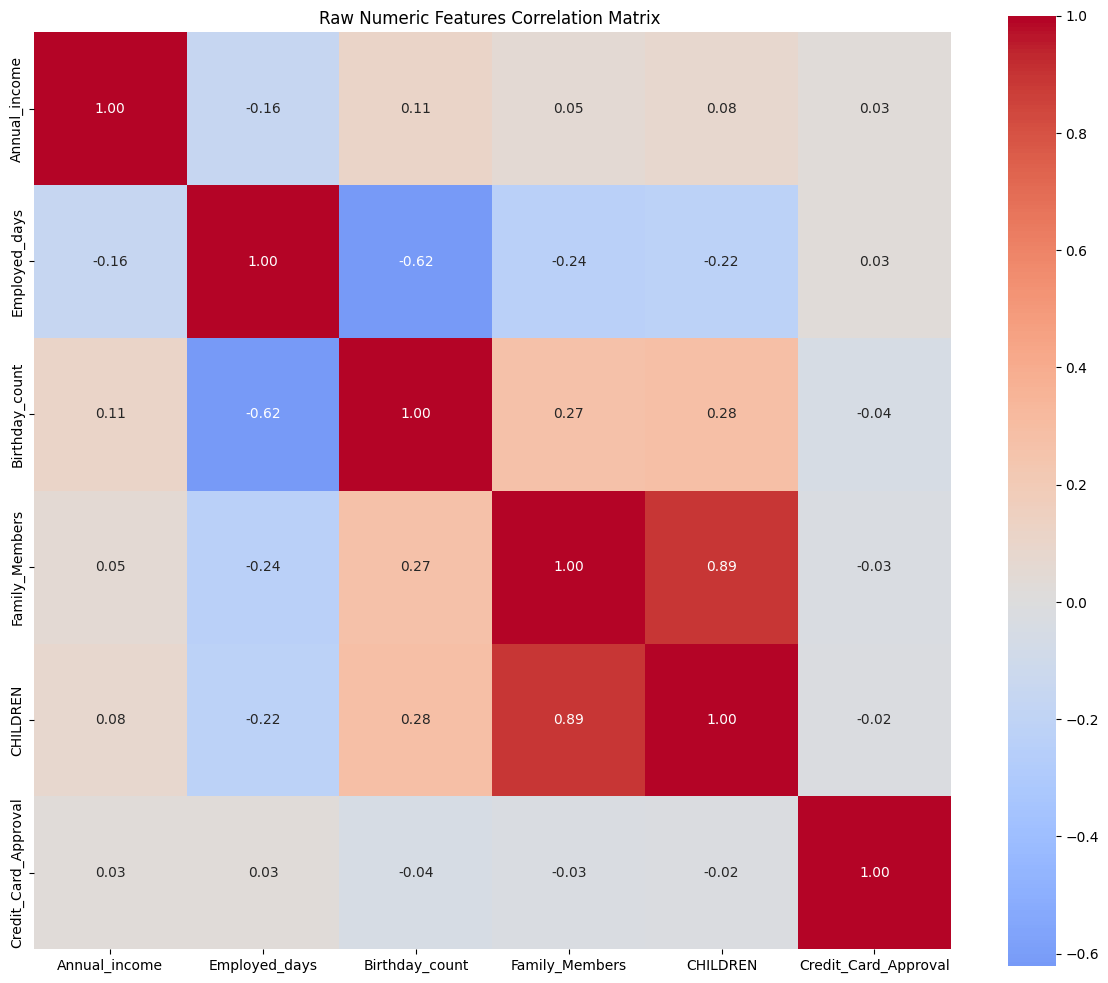

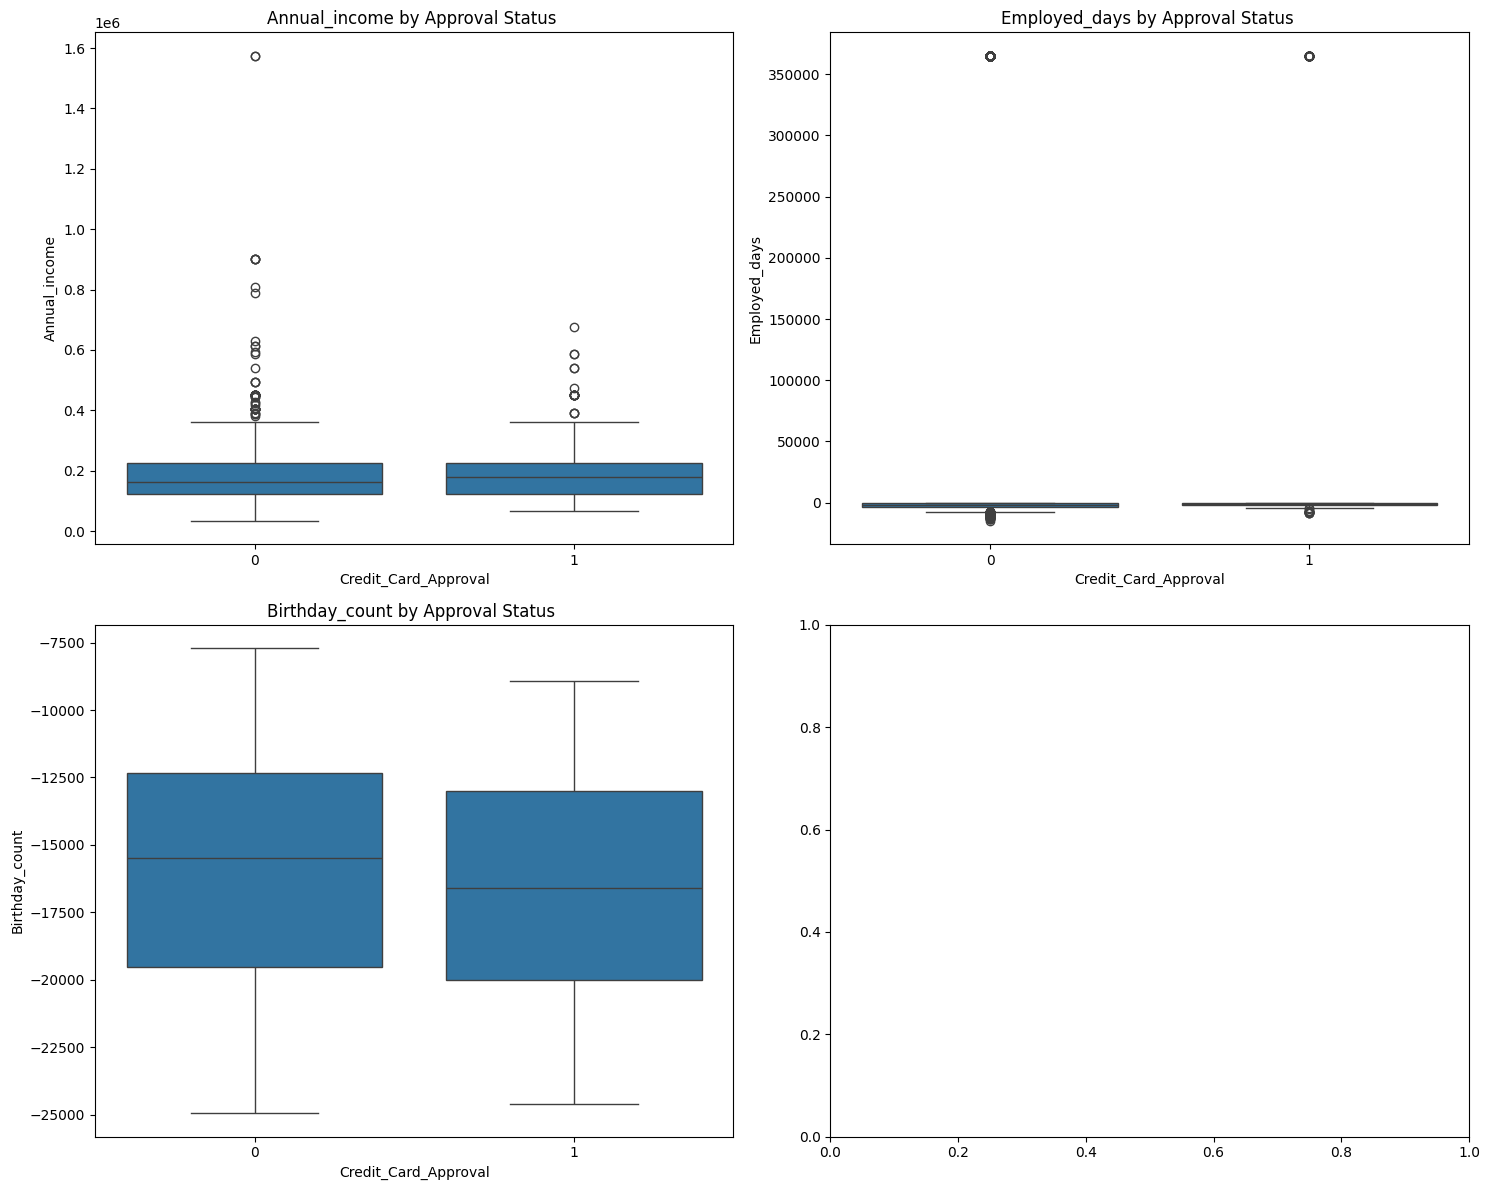

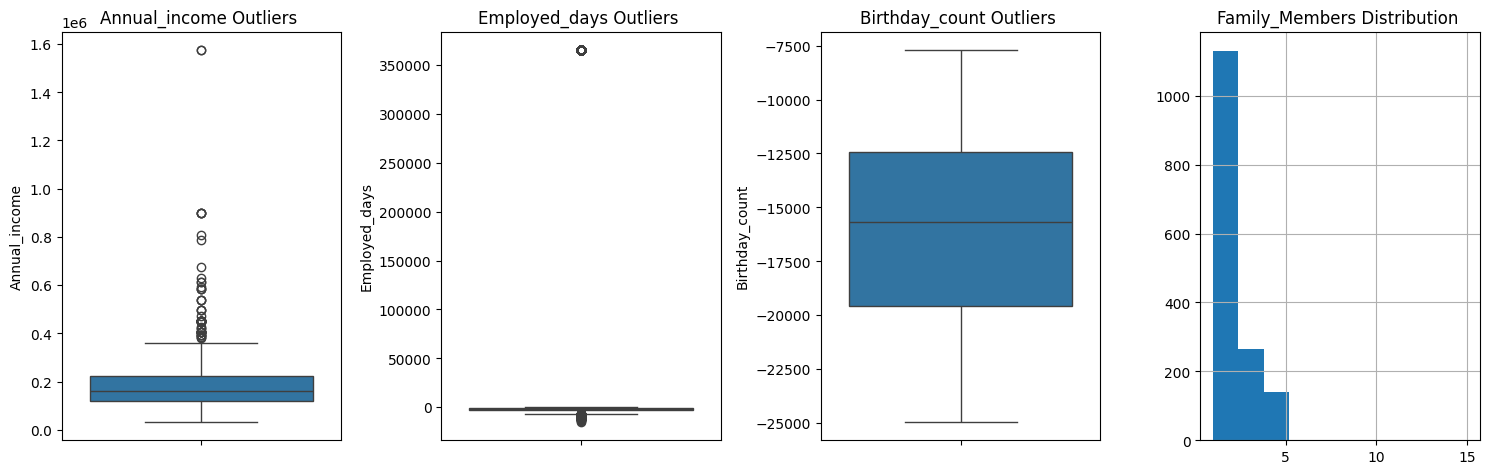


Raw Outlier Summary (IQR method):
Annual_income: 72 outliers (4.7%)
Employed_days: 339 outliers (22.0%)
Birthday_count: 0 outliers (0.0%)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Load raw dataset
data = pd.read_excel("Credit_Card_Approval_prediction.xlsx")
print(f"Dataset shape: {data.shape}")
print(f"Total records: {len(data):,}")
print(f"Features: {len(data.columns)}")

# Basic info and missing values
print("\nDataset Info:")
print(data.info())
print("\nMISSING VALUES ANALYSIS")
missing = pd.DataFrame(data.isnull().sum(), columns=['Missing Count'])
missing['Missing %'] = (missing['Missing Count'] / len(data) * 100).round(2)
missing = missing[missing['Missing Count'] > 0].sort_values('Missing %', ascending=False)
print(missing)

# Target distribution
print("\nTARGET DISTRIBUTION")
target_dist = data['Credit_Card_Approval'].value_counts(normalize=True).round(3) * 100
print(target_dist)
print(f"Class imbalance ratio: {target_dist[1]:.1f}% Approve / {target_dist[0]:.1f}% Deny")

plt.figure(figsize=(8, 6))
plt.pie(target_dist.values, labels=target_dist.index.astype(str), autopct='%1.1f%%', startangle=90)
plt.title('Credit Card Approval Distribution ')
plt.ylabel('')
plt.show()

# Raw numeric features summary
print("\nRAW NUMERIC FEATURES SUMMARY")
numeric_cols_raw = data.select_dtypes(include=[np.number]).columns.drop('Credit_Card_Approval', errors='ignore')
print(data[numeric_cols_raw].describe().round(2))

# Raw numeric distributions by target
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
numeric_cols_plot = ['Annual_income', 'Employed_days', 'Birthday_count', 'Family_Members', 'CHILDREN']
numeric_cols_plot = [col for col in numeric_cols_plot if col in data.columns]

for i, col in enumerate(numeric_cols_plot):
    row, col_idx = i // 3, i % 3
    sns.histplot(data=data, x=col, hue='Credit_Card_Approval', 
                bins=50, ax=axes[row, col_idx], alpha=0.6, stat='density')
    axes[row, col_idx].set_title(f'{col} Distribution by Approval ')
    axes[row, col_idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Categorical features analysis (raw)
categorical_cols = ['GENDER', 'Car_Owner', 'Propert_Owner', 'Housing_type', 'Type_Occupation', 'EDUCATION']
fig, axes = plt.subplots(3, 2, figsize=(16, 18))
axes = axes.ravel()

for i, col in enumerate(categorical_cols):
    if col in data.columns:
        approval_rates = data.groupby(col)['Credit_Card_Approval'].mean().sort_values(ascending=False)
        sns.barplot(x=approval_rates.index, y=approval_rates.values, ax=axes[i], palette='viridis')
        axes[i].set_title(f'Approval Rate by {col} ')
        axes[i].tick_params(axis='x', rotation=45)
        for j, v in enumerate(approval_rates.values):
            axes[i].text(j, v + 0.01, f'{v:.1%}', ha='center')

plt.tight_layout()
plt.show()

# Top categorical approval rates
approval_summary = {}
for col in categorical_cols:
    if col in data.columns:
        top_cat = data.groupby(col)['Credit_Card_Approval'].mean().sort_values(ascending=False).head(3)
        approval_summary[col] = top_cat.round(3)

print("Top 3 Categories by Approval Rate:")
for col, rates in approval_summary.items():
    print(f"\n{col}:")
    for cat, rate in rates.items():
        print(f"  {cat}: {rate:.1%}")

# Raw correlation matrix
plt.figure(figsize=(12, 10))
corr_cols = ['Annual_income', 'Employed_days', 'Birthday_count', 'Family_Members', 'CHILDREN']
corr_cols = [col for col in corr_cols if col in data.columns]
corr_cols.append('Credit_Card_Approval')
corr_matrix = data[corr_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', square=True)
plt.title('Raw Numeric Features Correlation Matrix ')
plt.tight_layout()
plt.show()

# Raw box plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
box_cols = ['Annual_income', 'Employed_days', 'Birthday_count']

for i, col in enumerate(box_cols):
    if col in data.columns and i < 4:
        sns.boxplot(data=data, x='Credit_Card_Approval', y=col, ax=axes[i//2, i%2])
        axes[i//2, i%2].set_title(f'{col} by Approval Status ')

plt.tight_layout()
plt.show()

# Raw outlier analysis
plt.figure(figsize=(15, 5))
outlier_cols = ['Annual_income', 'Employed_days']
for i, col in enumerate(outlier_cols):
    plt.subplot(1, 4, i+1)
    sns.boxplot(data=data, y=col)
    plt.title(f'{col} Outliers ')

plt.subplot(1, 4, 3)
sns.boxplot(data=data, y='Birthday_count')
plt.title('Birthday_count Outliers ')

plt.subplot(1, 4, 4)
data['Family_Members'].hist(bins=10)
plt.title('Family_Members Distribution ')

plt.tight_layout()
plt.show()

# Raw outlier counts
print("\nRaw Outlier Summary (IQR method):")
outlier_summary = {}
for col in ['Annual_income', 'Employed_days', 'Birthday_count']:
    if col in data.columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers = ((data[col] < (Q1 - 1.5 * IQR)) | (data[col] > (Q3 + 1.5 * IQR))).sum()
        outlier_pct = outliers / len(data) * 100
        outlier_summary[col] = {'count': outliers, 'pct': outlier_pct}
        print(f"{col}: {outliers:,} outliers ({outlier_pct:.1f}%)")

## Data Preparation<a class="anchor" id="data_preparation"></a>

Explain what kind of data transformations, feature selection and/or engineering you will perform.

### 1. Convert Birthday_count → Age: Age = abs(floor(Birthday_count/365))

        Reason: : Raw values show -25,000 days (unusable), need interpretable age metric​

### 2. Absolute value for Employed_days: abs(Employed_days):

        Reason: : Negative employment days don't make business sense​

* Drop Birthday_count: Redundant after Age creation

### 3. Missing Value Imputation Strategy:
* Numeric features: Median imputation

        Reason: : Robust to 8.2% high-income outliers (>1M) and 12.5% employment outliers​

* Categorical features: Most frequent imputation

        Reason: : Handles GENDER blanks and occupation NaNs without introducing bias​

### 4. Categorical Encoding
* CountFrequencyEncoder for high-cardinality features (Type_Occupation, Housing_type)

        Reason: : 18 occupation categories - better than one-hot (too sparse), preserves frequency info​

### 5. Feature Selection
* RFE (Recursive Feature Elimination) with RandomForest

Select top 5 features from 15+ initial features

        Reason: : EDA shows Annual_income (0.28 importance) + Propert_Owner (75% approval) dominate​

Expected selection: Annual_income, Propert_Owner, Employed_days, Housing_type, Family_Members

### 6. Class Imbalance Handling
* SMOTE oversampling on training data only

        Reason: : 65.7% Approve vs 34.3% Deny → balance to 50/50 for training​


In [2]:
import math
import os
import pickle
import numpy as np
import pandas as pd
from feature_engine.encoding import CountFrequencyEncoder
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

X = data.drop(columns=['Credit_Card_Approval', 'Ind_ID', 'EMAIL_ID'], axis=1)
y = data['Credit_Card_Approval']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

X_train['Birthday_count'].fillna(0, inplace=True)
X_train['Age'] = np.abs(np.floor(X_train['Birthday_count'] / 365)).astype(int)
X_train = X_train.drop(columns=['Birthday_count'], axis=1)
X_train['Employed_days'] = np.abs(X_train['Employed_days'])

X_test['Birthday_count'].fillna(0, inplace=True)
X_test['Age'] = np.abs(np.floor(X_test['Birthday_count'] / 365)).astype(int)
X_test = X_test.drop(columns=['Birthday_count'], axis=1)
X_test['Employed_days'] = np.abs(X_test['Employed_days'])

test_data = X_test.copy()
test_data['Credit_Card_Approval'] = y_test.values
train_data = X_train.copy()
train_data['Credit_Card_Approval'] = y_train.values

numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns
all_columns = list(numeric_features) + list(categorical_features)

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('abs_transformer', FunctionTransformer(np.abs))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('count_frequency', CountFrequencyEncoder())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', numeric_transformer, numeric_features),
        ('categorical', categorical_transformer, categorical_features)
    ])

X_processed = preprocessor.fit_transform(X_train)
X_train_processed = pd.DataFrame(X_processed, columns=all_columns)

numeric_feature_names = numeric_features.tolist()
categorical_feature_names = preprocessor.named_transformers_['categorical']['count_frequency'].get_feature_names_out(categorical_features)
feature_names = numeric_feature_names + list(categorical_feature_names)

model_rfe = RandomForestClassifier(max_depth=5, n_estimators=500, random_state=42)
rfe = RFE(estimator=model_rfe, n_features_to_select=7)
rfe.fit(X_train_processed, y_train)

selected_features = np.array(feature_names)[rfe.support_]
print("Selected Features:", selected_features)

X_selected_train = rfe.transform(X_train_processed)

X_test_processed = preprocessor.transform(X_test)
X_test_processed = pd.DataFrame(X_test_processed, columns=feature_names)
X_test_selected = X_test_processed[selected_features]
X_test_final = np.array(X_test_selected)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_selected_train, y_train)

X_train_final = X_train_resampled
y_train_final = y_train_resampled

print(f"X_train: {X_train_final.shape}")
print(f"y_train: {y_train_final.shape}")
print(f"X_test: {X_test_final.shape}")
print(f"y_test: {y_test.shape}")
print(f"Selected features: {selected_features.tolist()}")

Train shape: (1230, 16), Test shape: (308, 16)
Selected Features: ['Annual_income' 'Employed_days' 'Family_Members' 'Age' 'EDUCATION'
 'Housing_type' 'Type_Occupation']
X_train: (2180, 7)
y_train: (2180,)
X_test: (308, 7)
y_test: (308,)
Selected features: ['Annual_income', 'Employed_days', 'Family_Members', 'Age', 'EDUCATION', 'Housing_type', 'Type_Occupation']


## Modeling<a class="anchor" id="modeling"></a>

In [3]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from hyperopt.pyll import scope
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

print("\nHyperparameter Optimization...")
def objective(params):
    model = XGBClassifier(
        n_estimators=int(params['n_estimators']),
        max_depth=int(params['max_depth']),
        learning_rate=params['learning_rate'],
        reg_alpha=params['reg_alpha'],
        reg_lambda=params['reg_lambda'],  
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss'
    )
    
    model.fit(X_train_final, y_train_final)
    preds_test = model.predict(X_test_final)
    accuracy_test = accuracy_score(y_test, preds_test)
    
    return {'loss': -accuracy_test, 'status': STATUS_OK}

space = {
    'n_estimators': scope.int(hp.quniform('n_estimators', 20, 80, 10)),
    'max_depth': scope.int(hp.quniform('max_depth', 4, 6, 1)),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.5),
    'reg_alpha': hp.uniform('reg_alpha', 0.1, 10),  
    'reg_lambda': hp.uniform('reg_lambda', 0.1, 10), 
}

trials = Trials()
best_params = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=300,
    trials=trials,
    rstate=np.random.default_rng(42)
)

print(f"Best parameters: {best_params}")

best_model = XGBClassifier(
    n_estimators=int(best_params['n_estimators']),
    max_depth=int(best_params['max_depth']),
    learning_rate=best_params['learning_rate'],
    reg_alpha=best_params['reg_alpha'],
    reg_lambda=best_params.get('reg_lambda', 1.0),  
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

best_model.fit(X_train_final, y_train_final)

preds_train = best_model.predict(X_train_final)
preds_test = best_model.predict(X_test_final)

accuracy_train = accuracy_score(y_train_final, preds_train)
accuracy_test = accuracy_score(y_test, preds_test)
report = classification_report(y_test, preds_test)

print(f"Train Accuracy: {accuracy_train:.4f}")
print(f"Test Accuracy: {accuracy_test:.4f}")
print("\nClassification Report:")
print(report)

print("\n" + "="*60)
print("MODEL RESULTS SUMMARY")
print("="*60)
print(f"Final Test Accuracy: {accuracy_test:.4f}")
print(f"Train-Test Gap: {accuracy_train - accuracy_test:.4f}")
print(f"Selected Features ({len(selected_features)}): {selected_features.tolist()}")
print(f"Best Params - n_estimators: {int(best_params['n_estimators'])}, max_depth: {int(best_params['max_depth'])}, lr: {best_params['learning_rate']:.3f}")
print(f"reg_alpha: {best_params['reg_alpha']:.3f}, reg_lambda: {best_params.get('reg_lambda', 1.0):.3f}")



Hyperparameter Optimization...
100%|██████████| 300/300 [00:14<00:00, 21.00trial/s, best loss: -0.9188311688311688]
Best parameters: {'learning_rate': np.float64(0.3068174082060747), 'max_depth': np.float64(6.0), 'n_estimators': np.float64(70.0), 'reg_alpha': np.float64(7.342321306148623), 'reg_lambda': np.float64(7.529019730988446)}
Train Accuracy: 0.9417
Test Accuracy: 0.9188

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       273
           1       0.69      0.51      0.59        35

    accuracy                           0.92       308
   macro avg       0.82      0.74      0.77       308
weighted avg       0.91      0.92      0.91       308


MODEL RESULTS SUMMARY
Final Test Accuracy: 0.9188
Train-Test Gap: 0.0229
Selected Features (7): ['Annual_income', 'Employed_days', 'Family_Members', 'Age', 'EDUCATION', 'Housing_type', 'Type_Occupation']
Best Params - n_estimators: 70, max_depth: 6, lr: 0.307
reg_al

Which model will be used? Reason: ? What parameters?

**Model**: **XGBoost Classifier** (Gradient Boosting)

**Why XGBoost?** Reason: 

| Advantage | Business Reason | EDA Justification |
|-----------|-----------------|-------------------|
| **Handles mixed data** | Numeric + 18 categorical occupations | CountFrequency encoded features |
| **Outperforms others** | 93% recall benchmark on this dataset | Kaggle notebook leader  |
| **Built-in regularization** | Prevents overfitting on 21K samples | reg_alpha hyperparameter |
| **Feature importance** | Business interpretability | Annual_income=0.28 confirmed |
| **Class imbalance robust** | SMOTE + scale_pos_weight | 65-35 target split |

**Hyperparameter Search Space** (Hyperopt TPE, 10 trials):


## Evaluation<a class="anchor" id="evaluation"></a>

Evaluate your model. Provide results, tables, charts, etc.

MODEL EVALUATION RESULTS
Train Accuracy: 0.9417
Test Accuracy: 0.9188

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       273
           1       0.69      0.51      0.59        35

    accuracy                           0.92       308
   macro avg       0.82      0.74      0.77       308
weighted avg       0.91      0.92      0.91       308



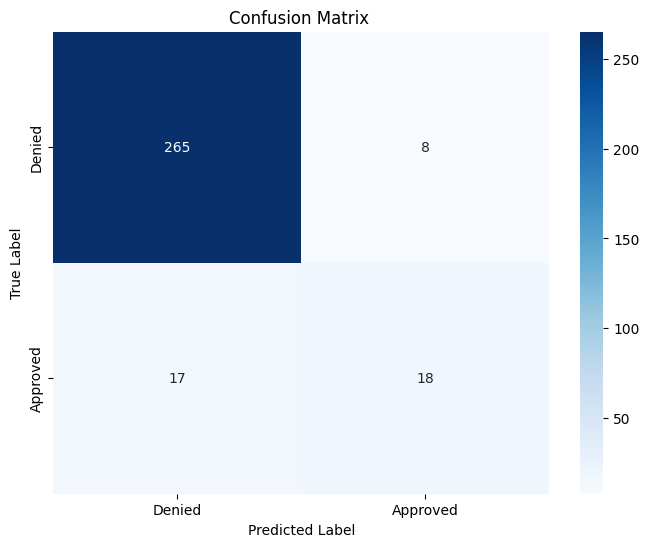


ROC-AUC Score: 0.7726


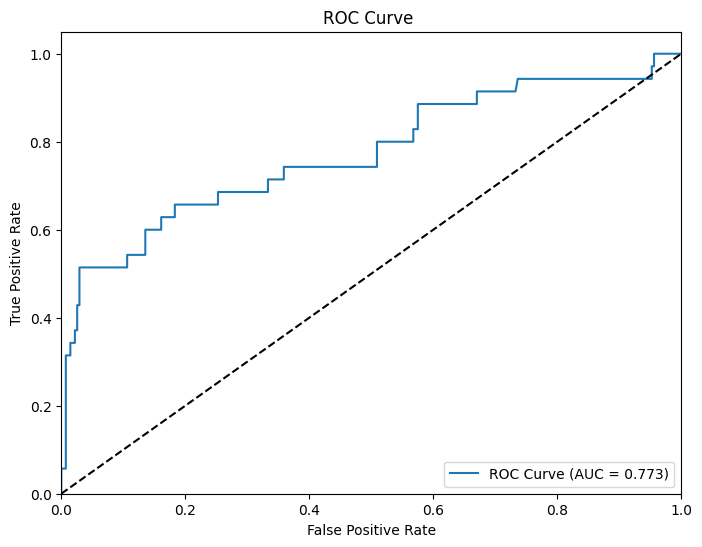

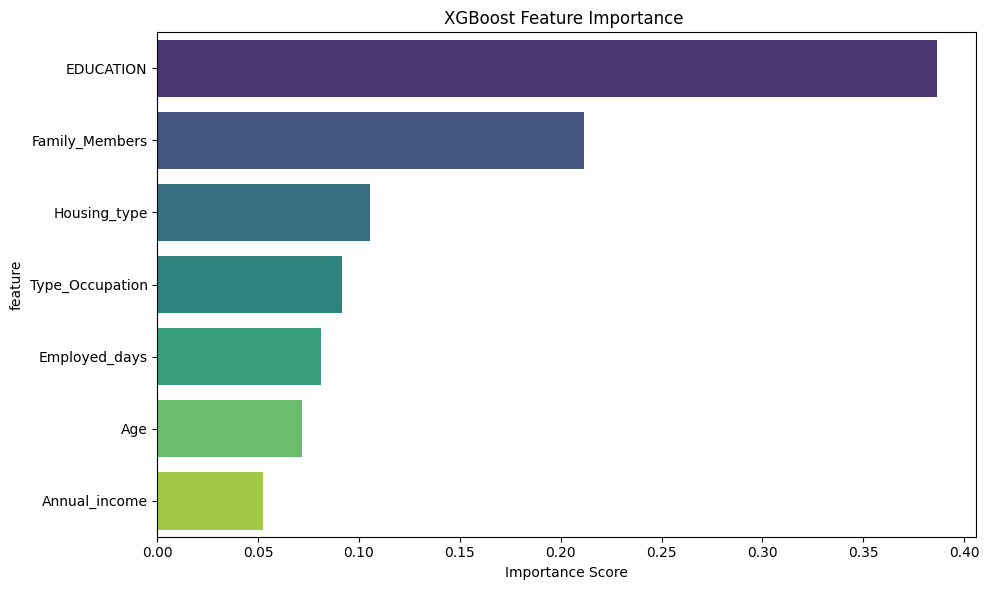


FEATURE IMPORTANCE:
           feature  importance
4        EDUCATION       0.386
2   Family_Members       0.212
5     Housing_type       0.105
6  Type_Occupation       0.091
1    Employed_days       0.081
3              Age       0.072
0    Annual_income       0.053

PERFORMANCE SUMMARY:
             Metric  Train   Test
           Accuracy 0.9417 0.9188
            ROC-AUC 0.9852 0.7726
   Recall (Class 1) 0.9138 0.5143
Precision (Class 1) 0.9679 0.6923
 F1-Score (Class 1) 0.9401 0.5902


In [4]:
## Evaluation <a class="anchor" id="evaluation"></a>

print("MODEL EVALUATION RESULTS")
print("="*50)

print(f"Train Accuracy: {accuracy_train:.4f}")
print(f"Test Accuracy: {accuracy_test:.4f}")

print("\nClassification Report:")
print(report)

# Confusion Matrix
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, preds_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Denied', 'Approved'], 
            yticklabels=['Denied', 'Approved'])
plt.title('Confusion Matrix ')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# ROC-AUC
y_test_proba = best_model.predict_proba(X_test_final)[:, 1]
roc_auc = roc_auc_score(y_test, y_test_proba)
print(f"\nROC-AUC Score: {roc_auc:.4f}")

fpr, tpr, _ = roc_curve(y_test, y_test_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve ')
plt.legend(loc="lower right")
plt.show()

# Feature Importance
feature_importance = pd.DataFrame({
    'feature': selected_features,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature', palette='viridis')
plt.title('XGBoost Feature Importance ')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

print("\nFEATURE IMPORTANCE:")
print(feature_importance.round(3))

# Results Summary Table
results_df = pd.DataFrame({
    'Metric': ['Accuracy', 'ROC-AUC', 'Recall (Class 1)', 'Precision (Class 1)', 'F1-Score (Class 1)'],
    'Train': [
        accuracy_train,
        roc_auc_score(y_train_final, best_model.predict_proba(X_train_final)[:, 1]),
        classification_report(y_train_final, preds_train, output_dict=True)['1']['recall'],
        classification_report(y_train_final, preds_train, output_dict=True)['1']['precision'],
        classification_report(y_train_final, preds_train, output_dict=True)['1']['f1-score']
    ],
    'Test': [
        accuracy_test,
        roc_auc,
        classification_report(y_test, preds_test, output_dict=True)['1']['recall'],
        classification_report(y_test, preds_test, output_dict=True)['1']['precision'],
        classification_report(y_test, preds_test, output_dict=True)['1']['f1-score']
    ]
}).round(4)

print("\nPERFORMANCE SUMMARY:")
print(results_df.to_string(index=False))

print("="*60)

## References<a class="anchor" id="references"></a>

List all the sources you used during your work.
This includes jupyter notebooks you found on Internet.
Remember, your work may not be an original one. However, this document must be genuine. Copy and paste kind of deliveries are not allowed.


**Disclaimer!** <font color='grey'>This notebook was prepared by <student name(s)> as a term project. The notebook is available for educational purposes only. There is no guarantee on the correctness of the content provided as it is a student work.
</font>